In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## ГИПЕРПАРАМЕТРЫ

In [ ]:
N_ARTICLES = 10 # 1
TFIDF_MIN_DF = 3
TFIDF_MAX_FEATURES = 15000 # 5000

## ИНДЕКС 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# nasdaq = pd.read_csv('^IXIC.csv')
# sp500 = pd.read_csv('sp500_mktwtch.csv')

# sp500 = pd.read_csv('^spx_d.csv')
sp500 = pd.read_csv('/content/drive/My Drive/thesis/^spx_d-2008.csv')

In [ ]:
# добавим дату в формате даты 
sp500['dt'] = sp500['Date'].astype('datetime64[ns]')
sp500 = sp500.drop(columns='Date')
print(min(sp500['dt']), max(sp500['dt']))

2008-10-02 00:00:00 2020-02-13 00:00:00


In [ ]:
# остортируем по дате и пронумеруем строки 
sp500 = sp500.sort_values(by='dt')
idx = np.arange(len(sp500))
sp500['idx'] = idx 

In [ ]:
print(len(sp500), len(sp500['dt'].unique()))
sp500.head()

2861 2861


,Open,High,Low,Close,Volume,dt,idx
0,1161.06,1161.06,1111.43,1114.28,3492022222,2008-10-02,0
1,1114.28,1153.82,1098.14,1099.23,3731177778,2008-10-03,1
2,1099.23,1099.23,1007.97,1056.89,4420011111,2008-10-06,2
3,1056.89,1072.91,996.23,996.23,3927338889,2008-10-07,3
4,996.23,1021.06,970.97,984.94,4842405556,2008-10-08,4


In [ ]:
# таргет 
# строго больше, если равно, считаем, что из-за комиссии в убытке. 
# В остальном, комиссией пренебрегаем
target_sp = np.where(sp500['Close'] > sp500['Open'], 1, 0) 
sp500['target'] = target_sp

In [ ]:
# немного эквилибристики. соберем датасет дата-данные_за_прошлый_день 
prev_day_stat = sp500
prev_day_stat['prev_idx'] = prev_day_stat['idx'] + 1 
prev_day_stat = prev_day_stat.drop(columns='idx')
prev_day_stat['idx'] = prev_day_stat['prev_idx']
prev_day_stat = prev_day_stat.drop(columns='prev_idx')

prev_day_stat['chng_prev'] = prev_day_stat['Close'] - prev_day_stat['Open']
prev_day_stat['candle_h_prev'] = prev_day_stat['High'] - prev_day_stat['Low']

sp500_enrich = sp500.set_index('idx').join(prev_day_stat[['idx', 'chng_prev', 'candle_h_prev', 
                                               'Close', 'Volume']].set_index('idx'), 
                                           rsuffix='_prev', how='inner').reset_index()

In [ ]:
sp500_df = sp500_enrich[['dt', 'chng_prev', 'candle_h_prev', 
                         'Close_prev', 'Volume_prev', 'target']] 
print(sp500_df.shape)
sp500_df.head()

(2860, 6)


,dt,chng_prev,candle_h_prev,Close_prev,Volume_prev,target
0,2008-10-03,-46.78,49.63,1114.28,3492022222,0
1,2008-10-06,-15.05,55.68,1099.23,3731177778,0
2,2008-10-07,-42.34,91.26,1056.89,4420011111,0
3,2008-10-08,-60.66,76.68,996.23,3927338889,0
4,2008-10-09,-11.29,50.09,984.94,4842405556,0


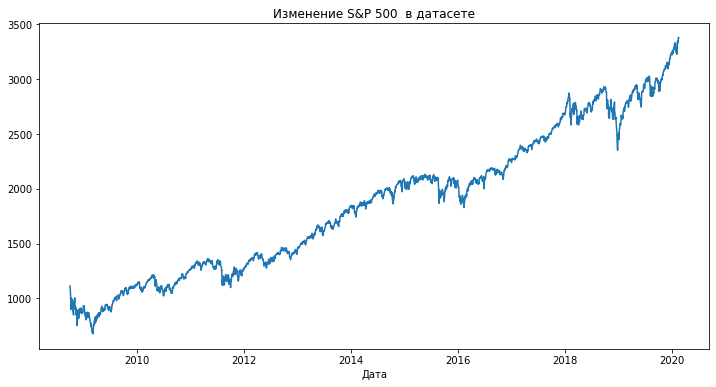

In [ ]:
fig, ax = plt.subplots()
ax.plot(sp500['dt'], sp500['Close'])

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('Изменение S&P 500  в датасете')
ax.set_xlabel('Дата') 

plt.show()

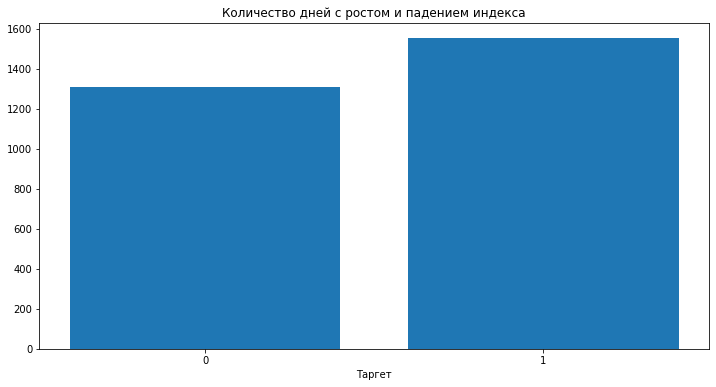

In [ ]:
fig, ax = plt.subplots()
# ax.hist(sp500_df['target'], bins=3)
ax.bar([0, 1],  list(sp500_df[['dt', 'target']].groupby(by='target').count()['dt']))

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('Количество дней с ростом и падением индекса')
ax.set_xlabel('Таргет') 
ax.set_xticks([0, 1])

plt.show()

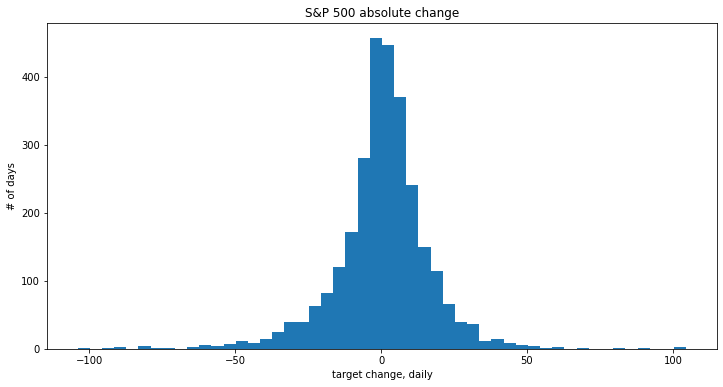

In [ ]:
fig, ax = plt.subplots()
ax.hist(sp500_df['chng_prev'], bins=50)

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('S&P 500 absolute change')
ax.set_xlabel('target change, daily') 
ax.set_ylabel('# of days') 

plt.show()

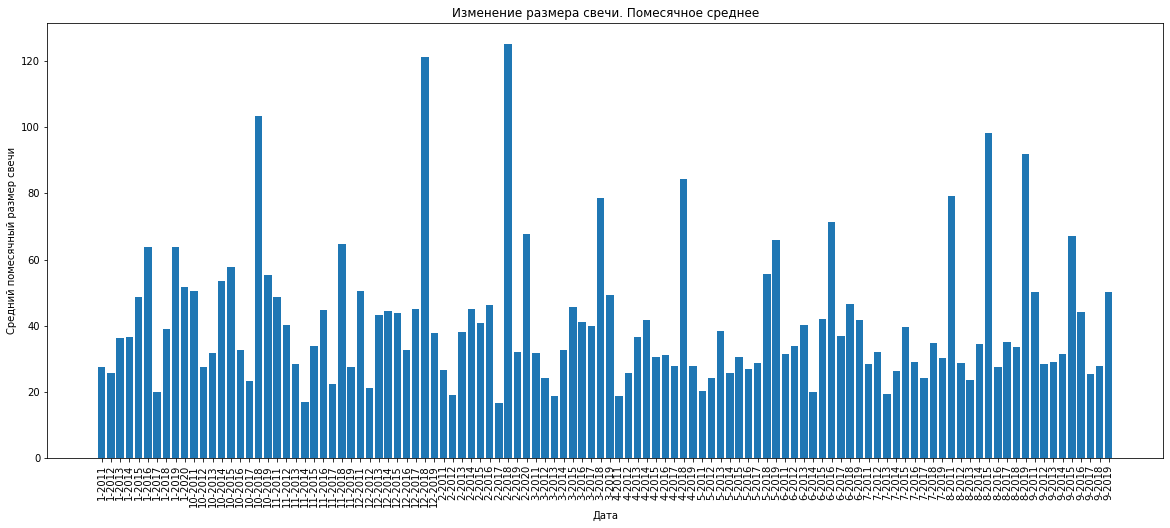

In [ ]:
fig, ax = plt.subplots()
plotter_my = sp500_df[['dt', 'candle_h_prev']][sp500_df['dt'] >= '2011-01-01']
plotter_my['my'] = plotter_my['dt'].dt.month.astype(str) + '-' + plotter_my['dt'].dt.year.astype(str)
aaaa = plotter_my[['my', 'candle_h_prev']].groupby('my').mean()
plotter_my = plotter_my.set_index('my').join(aaaa, rsuffix='_mean').reset_index()
plotter_my = plotter_my[['my', 'candle_h_prev']].drop_duplicates()

ax.bar(plotter_my['my'], plotter_my['candle_h_prev'])

fig.set_figwidth(20) 
fig.set_figheight(8)
ax.set_title('Candle size. Monthly average')
ax.set_xlabel('Date') 
ax.set_ylabel('Средний помесячный размер свечи') 

plt.xticks(rotation=90)
plt.show()

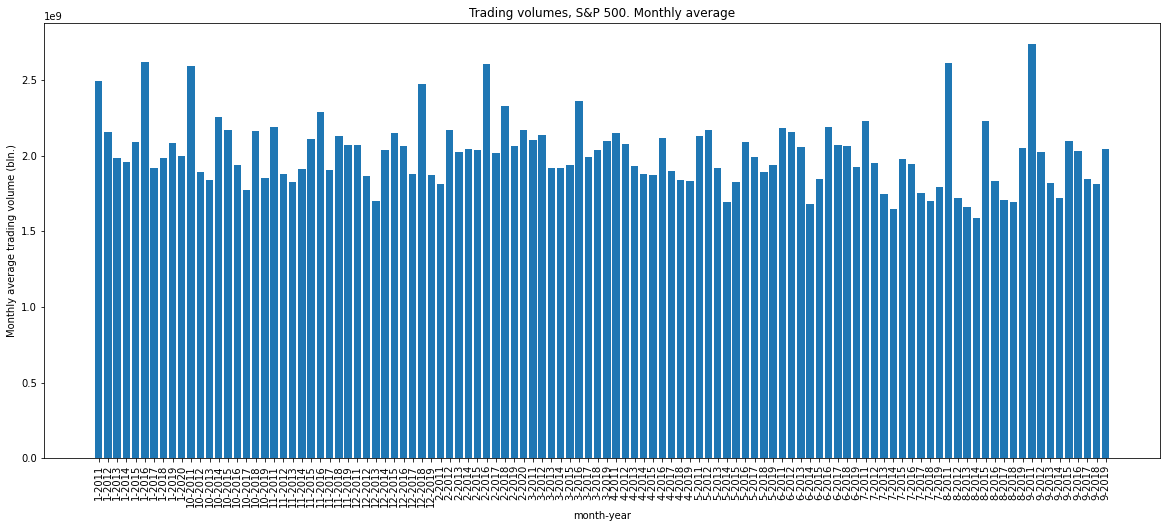

In [ ]:
fig, ax = plt.subplots()
# ax.hist(sp500_df['Volume_prev'], bins=50)
plotter_my = sp500_df[['dt', 'Volume_prev']][sp500_df['dt'] >= '2011-01-01']
plotter_my['my'] = plotter_my['dt'].dt.month.astype(str) + '-' + plotter_my['dt'].dt.year.astype(str)
aaaa = plotter_my[['my', 'Volume_prev']].groupby('my').mean()
plotter_my = plotter_my.set_index('my').join(aaaa, rsuffix='_mean').reset_index()
plotter_my = plotter_my[['my', 'Volume_prev_mean']].drop_duplicates()

ax.bar(plotter_my['my'], plotter_my['Volume_prev_mean'])

fig.set_figwidth(20) 
fig.set_figheight(8)
ax.set_title('Trading volumes, S&P 500. Monthly average')
ax.set_xlabel('month-year') 
ax.set_ylabel('Monthly average trading volume (bln.)') 

plt.xticks(rotation=90)
plt.show()

## ДАТАСЕТ НОВОСТЕЙ  

In [ ]:
# reut = pd.read_csv('reuters_headlines.csv') 

reut = pd.read_csv('/content/drive/My Drive/thesis/us_equities_news_dataset.csv')
reut['Time'] = reut['release_date']
reut['Headlines'] = reut['title']
reut['Description'] = reut['content']
reut = reut[['Time', 'Headlines', 'Description']].dropna()

In [ ]:
print(reut.shape)
print(reut.isna().sum())
reut.head() 

(221505, 3)
Time           0
Headlines      0
Description    0
dtype: int64


,Time,Headlines,Description
0,2020-01-15,Why Shares of Chinese Electric Car Maker NIO A...,What s happening\nShares of Chinese electric c...
1,2020-01-18,NIO only consumer gainer Workhorse Group amon...,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...
2,2020-01-15,NIO leads consumer gainers Beyond Meat and Ma...,Gainers NIO NYSE NIO 14 Village Farms In...
3,2020-01-15,NIO NVAX among premarket gainers,Cemtrex NASDAQ CETX 85 after FY results \n...
4,2020-01-06,PLUG NIO among premarket gainers,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...


In [ ]:
# добавим даты в формате дат 
month_cal = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 
            'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
            'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}


def str_to_dt(string):
    year = string[7:]
    month = month_cal[string[:3]]
    day = string[4:6]
    date_format = year + '-' + month + '-' + day
    return date_format


# добавим даты в формате дат
# reut['dt'] = reut['Time'].apply(str_to_dt).astype('datetime64[ns]')
reut['dt'] = reut['Time'].astype('datetime64[ns]')
min(reut['dt']), max(reut['dt'])

(Timestamp('2008-10-02 00:00:00'), Timestamp('2020-02-13 00:00:00'))

In [ ]:
# reut.set_index('dt').join(sp500_df.set_index('dt')).reset_index()
reut.set_index('dt').join(sp500_df.set_index('dt')).reset_index().head(3)

,dt,Time,Headlines,Description,chng_prev,candle_h_prev,Close_prev,Volume_prev,target
0,2008-10-02,2008-10-02,Nikkei down 1 4 pct on economy fears autos drop,Nikkei down 1 4 pct hits lowest point in ove...,NaN,NaN,NaN,NaN,NaN
1,2008-10-03,2008-10-03,FOREX Dollar poised for biggest weekly gain in...,Money market squeeze ECB shift fuel dollar ...,-46.78,49.63,1114.28,3.492022e+09,0.0
2,2008-10-03,2008-10-03,GLOBAL MARKETS Stocks rally on Wells Wachovia ...,U S stocks rally dollar gains on European w...,-46.78,49.63,1114.28,3.492022e+09,0.0


In [ ]:
# кол-во статей по дням 
headl_cnt = reut[['Headlines', 'dt']].groupby(by='dt', as_index=False).count()
headl_cnt['hcnt'] = headl_cnt['Headlines']
headl_cnt = headl_cnt[['dt', 'hcnt']]

(headl_cnt['hcnt'] < 5).sum(), (headl_cnt['hcnt'] >= 5).sum()

(532, 3109)

In [ ]:
# определили день недели 
# выходные отправляем в понедельник 

def wkday(date):
    return date.weekday() 

weekday_n = reut['dt'].apply(wkday)
reut['weekday_n'] = weekday_n 

In [ ]:
# Добавили подсчет заголовков в датасет 

reut_enrich = reut.set_index('dt').join(headl_cnt.set_index('dt')).reset_index()
reut_enrich.tail(3)

,dt,Time,Headlines,Description,weekday_n,hcnt
221502,2020-02-13,2020-02-13,3 Top Dividend Stocks To Maximize Your Retirem...,Strange but true seniors fear death less than...,3,41
221503,2020-02-13,2020-02-13,Improve Your Retirement Income With These 3 To...,Here s a revealing data point older Americans...,3,41
221504,2020-02-13,2020-02-13,Coronavirus Fears Re Emerge Bringing Risk Off...,Thursday Market Open Anyone who went to bed ...,3,41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


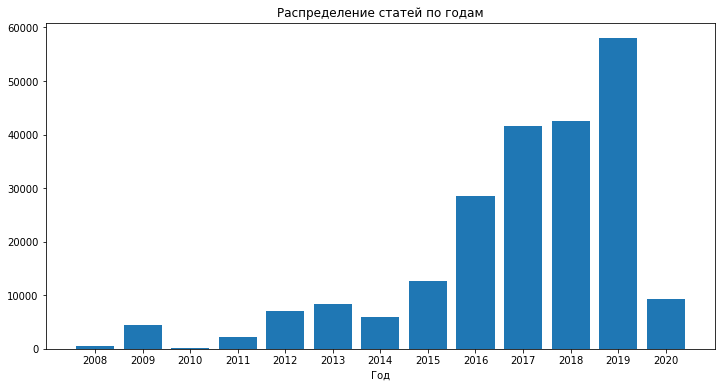

In [ ]:
def str_t_year(dt_str):
  return dt_str[:4]


plotter = reut_enrich[['Time', 'Headlines']]
plotter['Time'] = plotter['Time'].apply(str_t_year)
plotter_cnt = plotter.groupby('Time', as_index=False).count()

fig, ax = plt.subplots()
ax.bar(plotter_cnt['Time'], plotter_cnt['Headlines'])

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('Распределение статей по годам')
ax.set_xlabel('Год') 

plt.show()

# reut_enrich[reut_enrich['Time'].apply(str_t_year)=='2020'][['dt', 'Headlines']].groupby(by='dt', as_index=False).count().tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


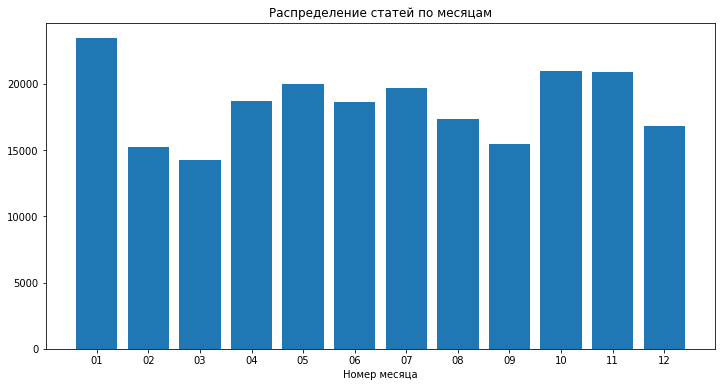

In [ ]:
def str_t_month(dt_str):
  return dt_str[5:7]

plotter = reut_enrich[['Time', 'Headlines']]
plotter['Time'] = plotter['Time'].apply(str_t_month)
plotter_cnt = plotter.groupby('Time', as_index=False).count()

fig, ax = plt.subplots()
ax.bar(plotter_cnt['Time'], plotter_cnt['Headlines'])

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('Распределение статей по месяцам')
ax.set_xlabel('Номер месяца') 

plt.show()

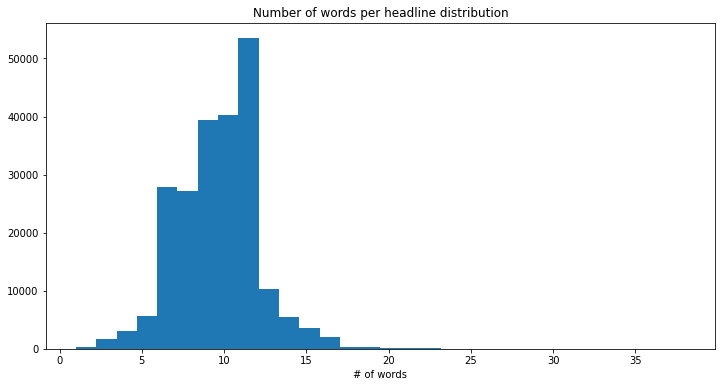

In [ ]:
# кол-во слов в заголовке
def splitter(text):
  return len(text.split())

fig, ax = plt.subplots()
ax.hist(reut_enrich['Headlines'].apply(splitter), bins=30)
# ax.hist(reut_enrich_gr_cut['Headlines'].apply(splitter), bins=30)

fig.set_figwidth(12) 
fig.set_figheight(6)
ax.set_title('Number of words per headline distribution')
ax.set_xlabel('# of words') 

plt.show()

In [ ]:
# считаем суммарное кол-во статей за выходные + пн для понедельников 
date_hcnt = reut_enrich[['dt', 'weekday_n', 'hcnt']].drop_duplicates()

sat_mn = np.where(date_hcnt['weekday_n'] == 5, date_hcnt['dt'] + pd.to_timedelta(2, unit='day'), 
                  date_hcnt['dt'] + pd.to_timedelta(9999, unit='day')) # ЧТОБЫ ТОЧНО НЕ БЫЛО ПЕРЕСЕЧЕНИЙ 
sun_mn = np.where(date_hcnt['weekday_n'] == 6, date_hcnt['dt'] + pd.to_timedelta(1, unit='day'), 
                  date_hcnt['dt'] + pd.to_timedelta(9999, unit='day'))

date_hcnt['sat_mn'] = sat_mn
date_hcnt['sun_mn'] = sun_mn

In [ ]:
sat_mn_df = date_hcnt[['sat_mn', 'hcnt']]
sun_mn_df = date_hcnt[['sun_mn', 'hcnt']]
date_hcnt = date_hcnt.drop(columns=['sat_mn', 'sun_mn'])


date_hcnt = date_hcnt.set_index('dt').join(sat_mn_df.set_index('sat_mn'), 
                                           rsuffix='_sat_hcnt', how='left').reset_index()
date_hcnt = date_hcnt.set_index('dt').join(sun_mn_df.set_index('sun_mn'), 
                                           rsuffix='_sun_hcnt', how='left').reset_index()

date_hcnt = date_hcnt.fillna(0)

date_hcnt['hcnt_gr'] = date_hcnt['hcnt'] + date_hcnt['hcnt_sat_hcnt'] + date_hcnt['hcnt_sun_hcnt'] 
date_hcnt = date_hcnt.drop(columns=['hcnt', 'hcnt_sat_hcnt', 'hcnt_sun_hcnt', 'weekday_n'])

In [ ]:
# Теперь в датасете для понедельников отображается в hcnt_gr сумарное кол-во статей за сб+вс+пн 
reut_enrich_gr = reut_enrich.set_index('dt').join(date_hcnt.set_index('dt'), how='left').reset_index().drop(columns='hcnt')

In [ ]:
# Пометим новости за сб и вс, как пн 

def wkday_to_mon(date):
    res = date.weekday()
    if res not in (5, 6):
        return res
    else: 
        return 0

reut_enrich_gr['weekday_shift'] = reut_enrich_gr['dt'].apply(wkday_to_mon)

In [ ]:
# reut_enrich_gr_weekday = reut_enrich_gr[reut_enrich_gr['weekday_n'] <= 4].drop(columns='hcnt')
# reut_enrich_gr_weekday.shape

ВООБЩЕ ЛУЧШЕ ВЗЯТЬ ВСЕ ДНИ, и просто наджойнивая на них индексы(**INNER**), останутся только нужные


## ПРЕДОБРАБОТКА ТЕКСТА 

ПОПРОБУЕМ СНАЧАЛА ОБРЕЗАТЬ ПО **5/10/N_ARTICLES** НОВОСТЕЙ / ДЕНЬ


In [ ]:
# ВСЯ НОВОСТЬ ВМЕСТО ЗАГОЛОВКА
# reut_enrich_gr['Headlines'] = reut_enrich_gr['Description']

In [ ]:
import random 

random.seed(13)
reut_enrich_gr_cut = pd.DataFrame(columns=['dt', 'Headlines'])
# N_ARTICLES = 5

for idt in set(reut_enrich_gr['dt']):
  art0 = list(reut_enrich_gr[reut_enrich_gr['dt'] == idt]['Headlines'])
  art_to_date = random.sample(art0, len(art0))[:N_ARTICLES]
  for i in range(min(len(art_to_date), N_ARTICLES)): 
    art_to_date_df = pd.DataFrame(
          [[str(idt), art_to_date[i]]], 
          columns=['dt', 'Headlines'])
    reut_enrich_gr_cut = reut_enrich_gr_cut.append(art_to_date_df)


reut_enrich_gr_cut['dt'] = reut_enrich_gr_cut['dt'].astype('datetime64[ns]')

In [ ]:
reut_enrich_gr_cut[reut_enrich_gr_cut['dt'] == '2019-01-17'].head()

,dt,Headlines
0,2019-01-17,The Zacks Analyst Blog Highlights NextEra We...
0,2019-01-17,Walmart partners with four more grocery delive...
0,2019-01-17,WEX Inks Deal To Purchase Discovery Benefits F...
0,2019-01-17,Stocks Morgan Stanley CSX Aurora Cannabis ...
0,2019-01-17,Top 5 Things to Know in The Market on Thursday


### Токенизация и Лемматизация

In [ ]:
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download("wordnet")

ttok = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

english_stopwords = stopwords.words("english")
# english_stopwords = []

def tok_n_join(text):
    tok_text = ttok.tokenize(text.lower())
    tok_text_clean = []
    for w in tok_text:
      if w not in english_stopwords:
        w_lem = lemmatizer.lemmatize(w)
        tok_text_clean.append(w_lem)
    return ' '.join(tok_text_clean)
    # return ' '.join(tok_text)

# headl_tok = reut_enrich_gr['Headlines'].apply(tok_n_join)
headl_tok = reut_enrich_gr_cut['Headlines'].apply(tok_n_join)
# headl_tok = reut_enrich_gr['Description'].apply(descr_cutter).apply(tok_n_join)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
### САМЫЕ ПОПУЛЯРНЫЕ СЛОВА ###
d_headl = {}

for article_text in list(headl_tok):
  for article_word in article_text.split(' '):
    if article_word in d_headl:
      d_headl[article_word] += 1
    else: 
      d_headl[article_word] = 1

d_headl_top = dict(sorted(d_headl.items(), key=lambda item: item[1], reverse=True)[:40])

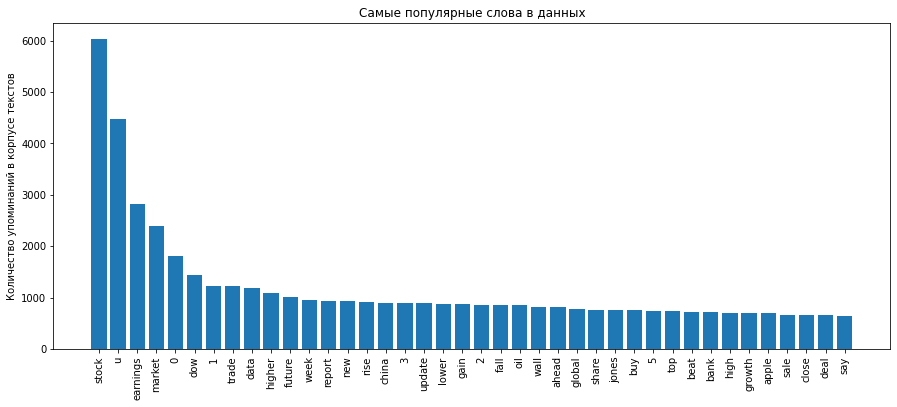

In [ ]:
# plt.bar(np.arange(len(d_headl_top.values())), d_headl_top.values())
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(d_headl_top.keys(), d_headl_top.values())
ax.set_title('Самые популярные слова в данных')
ax.set_ylabel('Количество упоминаний в корпусе текстов')

plt.xticks(rotation=90)
plt.show()

### Эмбеддинг

In [ ]:
# ### TF-IDF ###
# # np.random.seed(13)
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(min_df=TFIDF_MIN_DF, max_features=TFIDF_MAX_FEATURES) # , max_features=1000)
# headl_enc_spacy = tfidf.fit_transform(headl_tok)

In [ ]:
# ### SPACY ###
# np.random.seed(13)
# # ! python -m spacy download en_core_web_sm
# import spacy
# import en_core_web_sm

# spacy_enc = en_core_web_sm.load()
# # nlp = spacy.load('en_core_web_sm')

# def spacy_encoder(text):
#     return spacy_enc(text).vector


# # spaCy эмбеддинг с замером времени 

# import time 
# enc_start_dttm = time.time()
# headl_enc_spacy = headl_tok.apply(spacy_encoder)
# time.time() - enc_start_dttm

In [ ]:
spacy_enc_df = reut_enrich_gr_cut[['dt']]
# , 'weekday_n', 'hcnt_gr']]
# spaCy
spacy_enc_df['headl_enc'] = headl_tok
# tf-idf 
# spacy_enc_df['headl_enc'] = headl_enc_spacy.toarray().tolist()
spacy_enc_df.head(2)

,dt,headl_enc
0,2016-04-20,spell broken netflix like traditional tv network
0,2016-04-20,next e vix crude oil


Возьмем по N_ARTICLES статей за каждый день и объебиним их конкатенацией 

In [ ]:
# перенесем заголовки в столбцы и возьмем только 5 
# N_ARTICLES = 10
art_enc_flipped = pd.DataFrame(columns=['dt', 'articles_concat'])

for idt in set(spacy_enc_df['dt']): #spacy_enc_df['dt'].unique():

  art_to_date = list(spacy_enc_df[spacy_enc_df['dt'] == idt]['headl_enc'][:N_ARTICLES])
  art_to_date_concat = ''
  for i in range(len(art_to_date)): 
    # spaCy
    art_to_date_concat += art_to_date[i] + ' '
    # tf-idf
    # art_to_date_concat += art_to_date[i]
  art_to_date_full = [str(idt)] + [art_to_date_concat]
  art_to_date_df = pd.DataFrame(
        [art_to_date_full],
        columns=['dt', 'articles_concat'])
  art_enc_flipped = art_enc_flipped.append(art_to_date_df)


  # if len(art_to_date_concat) // emb_dimension >= N_ARTICLES:
  #   art_to_date_full = [str(idt)] + [art_to_date_concat]
  #   art_to_date_df = pd.DataFrame(
  #       [art_to_date_full],
  #       columns=['dt', 'articles_concat'])
  #   art_enc_flipped = art_enc_flipped.append(art_to_date_df)
  # else: 
  #   # был пустой список в эмбеддингах (видимо, пустой заголовок), поэтому размерности art_to_date и art_to_date_concat не совпали
  #   # diff = N_ARTICLES - len(art_to_date)
  #   # emb_dimension = len(list(spacy_enc_df['headl_enc'])[0])
  #   diff = N_ARTICLES - len(art_to_date_concat) // emb_dimension
  #   # art_to_date_full = [str(idt)] + art_to_date + diff*['']
  #   # заполним нулями недостающие статьи 
  #   # art_to_date_concat_full = art_to_date_concat + np.zeros(diff*96).tolist()
  #   art_to_date_concat_full = art_to_date_concat + np.zeros(diff*emb_dimension).tolist()
  #   art_to_date_full = [str(idt)] + [art_to_date_concat_full]
  #   art_to_date_df = pd.DataFrame(
  #       [art_to_date_full], 
  #       columns=['dt', 'articles_concat'])
  #   art_enc_flipped = art_enc_flipped.append(art_to_date_df)

In [ ]:
art_enc_flipped.head()
# sp500_df.dt[:10]
art_enc_flipped.shape, sp500_df.shape
art_enc_flipped.dt = pd.to_datetime(art_enc_flipped.dt)

In [ ]:
art_enc_flipped.head()

,dt,articles_concat
0,2016-04-20,spell broken netflix like traditional tv netwo...
0,2013-06-05,usd jpy bull 100 0 v bear 100 5 u k good news ...
0,2014-07-04,honda say expand u regional air bag recall inc...
0,2016-08-03,forget gold buy silver etf instead 4 stock wat...
0,2011-03-14,asia stock tumble japanese quake nikkei plunge...


### keras over texts concat

In [ ]:
# import spacy
# import gensim.downloader as api
# # Load the spacy model that you have installed
# # nlp = spacy.load('en_core_web_md')
# w2v = api.load('word2vec-google-news-300')

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

def splitter(x):
  return x.split(' ')

w2v = Word2Vec(sentences=art_enc_flipped.articles_concat.apply(splitter), 
               size=100, window=5, min_count=1) #, workers=4)
# w2v.save("word2vec.model")

In [ ]:
print(w2v['car'].shape)
w2v.most_similar(positive='cat')

(100,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('ralph', 0.9986608624458313),
 ('guide', 0.9985532760620117),
 ('nflx', 0.9984946846961975),
 ('lauren', 0.9984593987464905),
 ('roundup', 0.9980705976486206),
 ('might', 0.9980553388595581),
 ('tone', 0.9980517625808716),
 ('corporation', 0.9978456497192383),
 ('healthcare', 0.9977967143058777),
 ('dis', 0.9977138042449951)]

In [ ]:
len(w2v.wv.vocab)
w2v.wv['gold'].shape
# common_texts

(100,)

In [ ]:
from keras.layers import TextVectorization

art_enc_flipped.isna().sum()
Vectorizer = TextVectorization(max_tokens=30000)
Vectorizer.adapt(art_enc_flipped['articles_concat'].to_numpy())
vocab = Vectorizer.get_vocabulary()

In [ ]:
skip_vocab = list(map(str, vocab))
num_tokens = len(skip_vocab)
embedding_dim = len(w2v.wv['word']) # len(w2v['word'])
embedding_matrix = np.zeros((num_tokens, embedding_dim))

null_check_cnt = 0
for i, word in enumerate(skip_vocab):
  if i % 1000 == 0:
    print(i, word, end='; ')
  
  if word == '' or word == '[UNK]': 
    null_check_cnt += 1
  else: 
    if word in w2v.wv: # w2v: 
      embedding_matrix[i] = w2v.wv[word] # w2v[word]
    else: 
      null_check_cnt += 1

0 ; 1000 protest; 2000 suffers; 3000 eni; 4000 dunkin; 5000 pif; 6000 par; 7000 unleash; 8000 lamar; 9000 baro; 10000 transmitter; 11000 safeguard; 12000 orbit; 13000 karyopharm; 14000 flush; 15000 credential; 16000 atrion; 

In [ ]:
from keras import regularizers, optimizers, backend
from keras.layers import TextVectorization, Embedding, Dense, Dropout, Input
from keras.layers import LSTM, GlobalMaxPool1D, Softmax, Lambda
from keras.models import Sequential
from keras.initializers import Constant
import tensorflow as tf

print(embedding_matrix.shape)

Embedding_layer = Embedding(
    num_tokens, embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

(16776, 100)


In [ ]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(Vectorizer)
model.add(Embedding_layer)
model.add(LSTM(64, return_sequences=True))
model.add(Lambda(lambda x: backend.mean(x, axis=1)))
model.add(Dense(32, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dense(16, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dense(1, activation='sigmoid')) # tf.keras.activations.softmax

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics_list = tf.keras.metrics.AUC(curve='ROC')
loss_func = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=adam, loss=loss_func, metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 100)         1677600   
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          42240     
                                                                 
 lambda_2 (Lambda)           (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                      

In [ ]:
# индекс для финансового индекса 
sp500_df = sp500_enrich[['dt', 'chng_prev', 'candle_h_prev', 
                         'Close_prev', 'Volume_prev', 'target']] 
sp500_df = sp500_df.sort_values(by='dt') 
sp500_idxs = np.arange(len(sp500_df))
sp500_df['idx'] = sp500_idxs
sp500_df['prev_idx'] = sp500_df['idx'] + 1

sp500_df = sp500_df.set_index('idx').join(sp500_df[['prev_idx', 'dt']].set_index('prev_idx'), 
                                  rsuffix='_prev', how='inner').reset_index()

# объединим
# связываем индекс с предыдущим 
united_df = art_enc_flipped.set_index('dt').join(
    sp500_df.drop(columns=['dt', 'prev_idx']).set_index('dt_prev'), 
    rsuffix='_fin', how='inner').reset_index()

In [ ]:
united_df.head()

,level_0,articles_concat,index,chng_prev,candle_h_prev,Close_prev,Volume_prev,target
0,2016-04-20,spell broken netflix like traditional tv netwo...,1899,0.88,14.73,2102.40,2324933333,0
1,2013-06-05,usd jpy bull 100 0 v bear 100 5 u k good news ...,1175,-20.15,22.22,1608.90,2017972222,1
2,2016-08-03,forget gold buy silver etf instead 4 stock wat...,1972,6.98,11.23,2163.79,2103627778,1
3,2011-03-14,asia stock tumble japanese quake nikkei plunge...,615,-4.80,14.82,1296.39,2250205556,0
4,2013-03-01,sequestration time enter precious metal market...,1109,3.52,18.51,1518.20,2053116667,1


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(united_df['articles_concat'],
                                                  united_df['target'], test_size=0.3)

In [ ]:
model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=16, 
                          epochs=5, 
                          validation_split=0.1)

Epoch 1/5
105/105 [==============================] - 19s 113ms/step - loss: 0.6966 - accuracy: 0.5427 - val_loss: 0.7006 - val_accuracy: 0.4920
Epoch 2/5
105/105 [==============================] - 6s 55ms/step - loss: 0.6931 - accuracy: 0.5427 - val_loss: 0.7003 - val_accuracy: 0.4920
Epoch 3/5
105/105 [==============================] - 5s 45ms/step - loss: 0.6913 - accuracy: 0.5427 - val_loss: 0.6993 - val_accuracy: 0.4920
Epoch 4/5
105/105 [==============================] - 5s 46ms/step - loss: 0.6908 - accuracy: 0.5427 - val_loss: 0.6989 - val_accuracy: 0.4920
Epoch 5/5
105/105 [==============================] - 5s 45ms/step - loss: 0.6904 - accuracy: 0.5427 - val_loss: 0.6982 - val_accuracy: 0.4920


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support

pred_proba = model.predict(X_val)
pred = pred_proba.round()

print(accuracy_score(y_val, pred))
print(precision_recall_fscore_support(y_val, pred))
print(roc_auc_score(y_val, pred_proba))

0.550125313283208
(array([0.        , 0.55012531]), array([0., 1.]), array([0.        , 0.70978173]), array([359, 439]))
0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


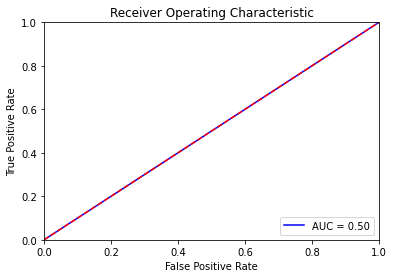

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_val, pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---

In [ ]:
# формат дат 
art_enc_flipped['dt'] = art_enc_flipped['dt'].astype('datetime64[ns]')

# объединим с числовыми данными о текстах 
reut_art_enc_df = art_enc_flipped.set_index('dt').join(
    reut_enrich_gr[['dt', 'weekday_n', 'hcnt_gr', 'weekday_shift']].set_index('dt')
  , how='inner').reset_index().drop_duplicates(subset=['dt'])

reut_art_enc_df = reut_art_enc_df.sort_values(by='dt')
reut_art_enc_df.head(2) 

,dt,articles_concat,weekday_n,hcnt_gr,weekday_shift
0,2008-10-02,"[-0.3580548167228699, -0.9777846932411194, -1....",3,1.0,3
1,2008-10-03,"[0.533836841583252, -0.9398090243339539, -0.75...",4,4.0,4


In [ ]:
reut_art_enc_df.head()
len(list(reut_art_enc_df['articles_concat'])[2]) , len(list(art_enc_flipped['articles_concat'])[4])
# len(list(spacy_enc_df['headl_enc'])[0])

(288, 288)

### Негативные слова

In [ ]:
! pip install pysentiment2

import pysentiment2 as ps
hiv4 = ps.HIV4()

     |████████████████████████████████| 1.9 MB 4.3 MB/s 


In [ ]:
def pos_neg_score(text):
  text_tokenized_hiv4 = hiv4.tokenize(text)
  pos = hiv4.get_score(text_tokenized_hiv4)['Positive']
  neg = hiv4.get_score(text_tokenized_hiv4)['Negative']
  len_sent = len(text.split(' '))

  return neg / len_sent


# neg_score = headl_tok.apply(pos_neg_score) # собран из reut_enrich_gr
neg_score = reut_enrich_gr['Headlines'].apply(tok_n_join).apply(pos_neg_score)
date_neg = reut_enrich_gr[['dt', 'hcnt_gr']] 
date_neg['neg_score'] = neg_score 
# neg_score = reut_enrich_gr_cut['Headlines'].apply(tok_n_join).apply(pos_neg_score)
# date_neg = pd.DataFrame(reut_enrich_gr_cut['dt'])
# date_neg['neg_score'] = neg_score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


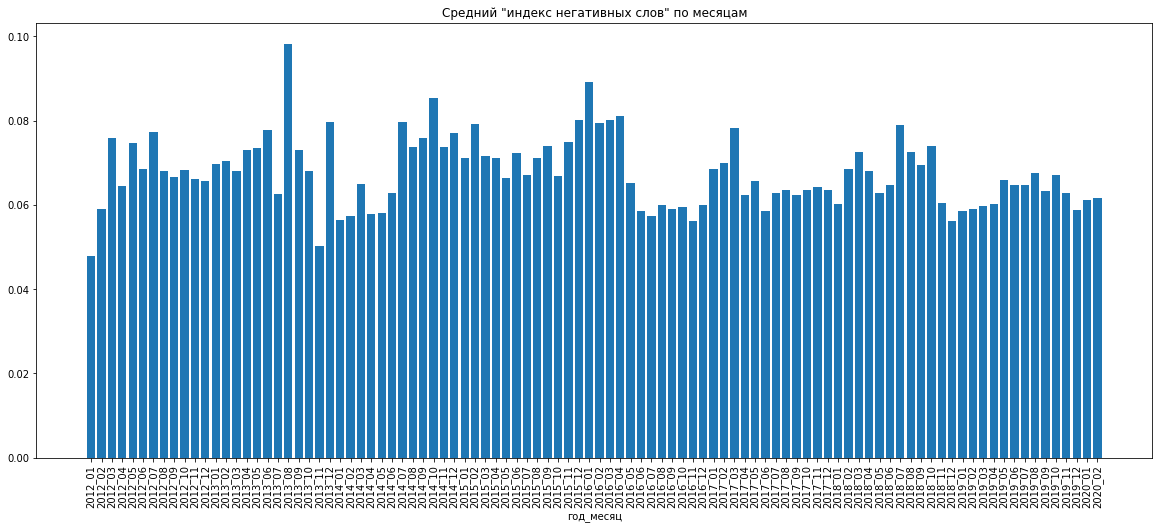

In [ ]:
# по headl_tok, построенному на reut_enrich_gr 
# plt.hist(date_neg['neg_score'][date_neg['neg_score'] != 0])

plotter = date_neg[date_neg['dt'] >= '2012-01-01']
plotter['year_month'] = date_neg['dt'].apply(str).apply(str_t_year) + '_' + date_neg['dt'].apply(str).apply(str_t_month)

ymmean = plotter[['year_month', 'neg_score']].groupby('year_month', as_index=False).mean()

fig, ax = plt.subplots()
ax.bar(ymmean['year_month'], ymmean['neg_score'])

fig.set_figwidth(20) 
fig.set_figheight(8)
ax.set_title('Средний \"индекс негативных слов\" по месяцам')
ax.set_xlabel('год_месяц') 
plt.xticks(rotation=90)

plt.show() 

In [ ]:
# получаем датасет с эмбеддингами, колич. данными о новостях и средним индексом негативности 
avg_neg_score = date_neg[['dt', 'neg_score']].groupby(by='dt', as_index=False).mean()
reut_enc_df = reut_art_enc_df.set_index('dt').join(avg_neg_score.set_index('dt')
                  , how='inner').reset_index()

reut_enc_df.head() 

,dt,articles_concat,weekday_n,hcnt_gr,weekday_shift,neg_score
0,2008-10-02,"[-0.3580548167228699, -0.9777846932411194, -1....",3,1.0,3,0.125000
1,2008-10-03,"[0.533836841583252, -0.9398090243339539, -0.75...",4,4.0,4,0.000000
2,2008-10-06,"[-0.16671057045459747, 0.7351138591766357, -1....",0,2.0,0,0.111111
3,2008-10-07,"[0.10771000385284424, 0.021953009068965912, -1...",1,2.0,1,0.111111
4,2008-10-08,"[0.3373503088951111, 0.6633867025375366, -1.19...",2,1.0,2,0.100000


## Объединим тексты новостей и индексы 

In [ ]:
# индекс для финансового индекса  
sp500_df = sp500_df.sort_values(by='dt') 
sp500_idxs = np.arange(len(sp500_df))
sp500_df['idx'] = sp500_idxs
sp500_df['prev_idx'] = sp500_df['idx'] + 1

sp500_df = sp500_df.set_index('idx').join(sp500_df[['prev_idx', 'dt']].set_index('prev_idx'), 
                                  rsuffix='_prev', how='inner').reset_index()

# объединим
# связываем индекс с предыдущим 
united_df = reut_enc_df.set_index('dt').join(
    sp500_df.drop(columns=['dt', 'prev_idx']).set_index('dt_prev'), 
    rsuffix='_fin', how='inner').reset_index()

**ВАЖНО**
В *united_df* *dt* и *target* относятся к таргет-дню(следующий после новости). Все остальные столбцы относятся к дню новостей. 

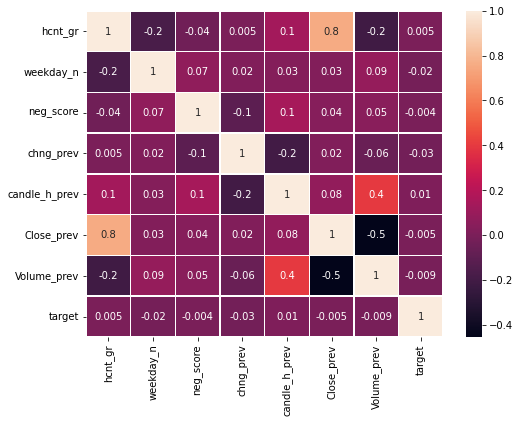

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(united_df[['hcnt_gr', 'weekday_n', 'neg_score', # 'weekday_shift'
              'chng_prev', 'candle_h_prev', 'Close_prev', 'Volume_prev', 'target']].corr(), annot=True, fmt='.1g', linewidths=.5)

## Построение модели 

### Бейзлайн 

In [ ]:
united_df.head(2)

,level_0,articles_concat,weekday_n,hcnt_gr,weekday_shift,neg_score,index,chng_prev,candle_h_prev,Close_prev,Volume_prev,target
0,2008-10-03,"[0.533836841583252, -0.9398090243339539, -0.75...",4,4.0,4,0.000000,1,-15.05,55.68,1099.23,3731177778,0
1,2008-10-06,"[-0.16671057045459747, 0.7351138591766357, -1....",0,2.0,0,0.111111,2,-42.34,91.26,1056.89,4420011111,0


In [ ]:
# масштабируем данные (скейлинг) 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.random.seed(13)


X0 = united_df[['hcnt_gr', 'weekday_n', 'neg_score', # 'weekday_shift'
               'chng_prev', 'candle_h_prev', 'Volume_prev']] # Close_prev не берем, поскольку высоко корредирован с другими 
# дамми дня текстов 
# выбросим дамми на один из дней недели во избежание дамми-трэп 
X_fin = pd.concat([X0, pd.get_dummies(X0['weekday_n'])], axis=1).drop(columns=['weekday_n', 4])

X_text = pd.DataFrame(np.array(list(united_df['articles_concat'])).reshape(united_df.shape[0], 
                                                                           len(united_df['articles_concat'][0])))

# масштабированные данные 
mmscaler = MinMaxScaler() 
# X_fin = unied_df[['hcnt_gr_scaled', 'weekday_shift_scaled', 'neg_score_scaled', 
#              t   'chng_prev_scaled', 'candle_h_prev_scaled', 'Close_prev_scaled', 'Volume_prev_scaled']]
X_fin['Volume_prev'] = united_df['Volume_prev'] / 10**9

X = pd.concat([X_fin, X_text], axis=1)
y = united_df['target']
X = pd.DataFrame(mmscaler.fit_transform(X), columns=X.columns)
# X['Volume_prev'] = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(X_train['Volume_prev'])))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
# X_train, X_val, y_train, y_val = train_test_split(X_fin, y, test_size=0.3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
np.random.seed(13)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)
accuracy_score(lr_pred, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.5

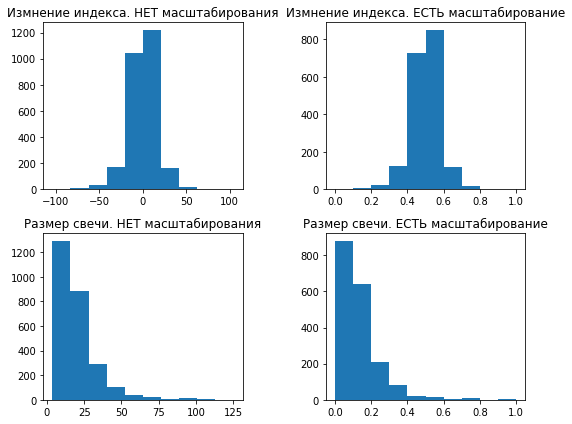

In [ ]:
lr.coef_[0][12]
# lr.coef_[0][:20]

fig, ax = plt.subplots(2, 2, figsize=(8,6),   )

ax[0, 0].hist(united_df['chng_prev'])
ax[0, 1].hist(X_train['chng_prev'])
ax[1, 0].hist(united_df['candle_h_prev'])
ax[1, 1].hist(X_train['candle_h_prev'])

ax[0, 0].set_title('Измнение индекса. НЕТ масштабирования')
ax[0, 1].set_title('Измнение индекса. ЕСТЬ масштабирование')
ax[1, 0].set_title('Размер свечи. НЕТ масштабирования')
ax[1, 1].set_title('Размер свечи. ЕСТЬ масштабирование')

fig.tight_layout() 

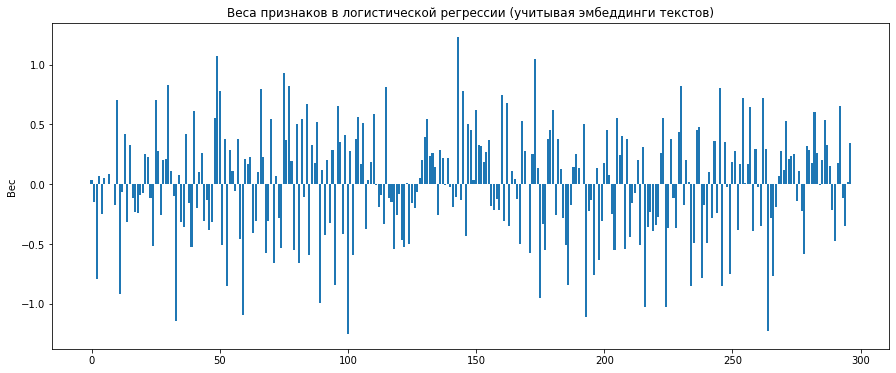

In [ ]:
# plt.bar(np.arange(10), lr.coef_[0][:10], )

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(np.arange(len(lr.coef_[0])), lr.coef_[0])
ax.set_title('Веса признаков в логистической регрессии (учитывая эмбеддинги текстов)')
ax.set_ylabel('Вес')

plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

lr.coef_[0][:10]
precision_recall_fscore_support(y_val, lr_pred, average='binary')

(0.5303643724696356, 0.6107226107226107, 0.5677139761646804, None)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


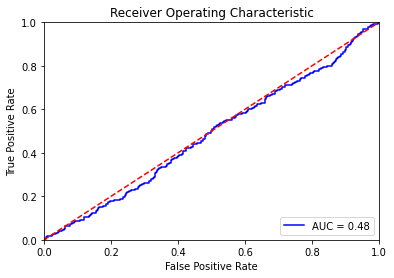

In [ ]:
import sklearn.metrics as metrics

preds = lr.predict_proba(X_val)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Precision-Recall curve. Accuracy: 0.50')

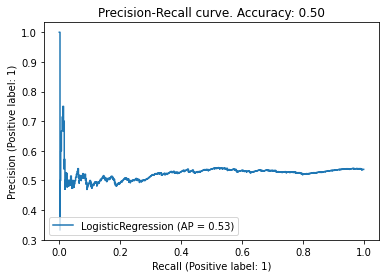

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr, X_val, y_val)
disp.ax_.set_title('Precision-Recall curve. Accuracy: {0:0.2f}'.format(accuracy_score(lr_pred, y_val)))

### LSTM

In [ ]:
united_df.head()

,level_0,articles_concat,weekday_n,hcnt_gr,weekday_shift,neg_score,index,chng_prev,candle_h_prev,Close_prev,Volume_prev,target
0,2008-10-03,"[0.533836841583252, -0.9398090243339539, -0.75...",4,4.0,4,0.000000,1,-15.05,55.68,1099.23,3731177778,0
1,2008-10-06,"[-0.16671057045459747, 0.7351138591766357, -1....",0,2.0,0,0.111111,2,-42.34,91.26,1056.89,4420011111,0
2,2008-10-07,"[0.10771000385284424, 0.021953009068965912, -1...",1,2.0,1,0.111111,3,-60.66,76.68,996.23,3927338889,0
3,2008-10-08,"[0.3373503088951111, 0.6633867025375366, -1.19...",2,1.0,2,0.100000,4,-11.29,50.09,984.94,4842405556,0
4,2008-10-09,"[0.8671865463256836, 0.38207077980041504, -2.2...",3,3.0,3,0.181481,5,-75.02,96.06,909.92,3788333333,0


In [ ]:
import numpy as np 
import tensorflow as tf
tf.random.set_seed(13)
np.random.seed(13)

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, GlobalMaxPool1D, Dropout, Lambda
from keras.backend import clear_session 

# построение модели 
model = Sequential()
model.add(Lambda(lambda x: x[:,:,:,0], input_shape=(*X_train.shape, 1)))
model.add(LSTM(32, input_dim=X_train.shape[1], return_sequences=True)) #, activation='relu'
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu')) #, input_dim=32
# model.add(layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# настройка  
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1862, 297)         0         
                                                                 
 lstm (LSTM)                 (None, 1862, 32)          42240     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

#### Dense attempt

In [ ]:
import numpy as np 
import tensorflow as tf
tf.random.set_seed(13)
np.random.seed(13)

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, GlobalMaxPool1D, Dropout, Lambda
from keras.backend import clear_session 

# построение модели 
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, input_dim=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# настройка  
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                9536      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10,081
Trainable params: 10,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# обучение
model.fit(X_train, y_train,
          epochs=30,
          verbose=True,
          validation_data=(X_val, y_val), 
          batch_size=8)

# почистить веса для перезапуска 
clear_session() 

Epoch 1/30
233/233 [==============================] - 3s 9ms/step - loss: 0.6914 - accuracy: 0.5451 - val_loss: 0.6961 - val_accuracy: 0.5376
Epoch 2/30
233/233 [==============================] - 1s 5ms/step - loss: 0.6918 - accuracy: 0.5424 - val_loss: 0.6905 - val_accuracy: 0.5376
Epoch 3/30
233/233 [==============================] - 1s 4ms/step - loss: 0.6907 - accuracy: 0.5424 - val_loss: 0.6910 - val_accuracy: 0.5376
Epoch 4/30
233/233 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.5424 - val_loss: 0.6914 - val_accuracy: 0.5376
Epoch 5/30
233/233 [==============================] - 1s 4ms/step - loss: 0.6900 - accuracy: 0.5424 - val_loss: 0.6910 - val_accuracy: 0.5376
Epoch 6/30
233/233 [==============================] - 1s 6ms/step - loss: 0.6901 - accuracy: 0.5424 - val_loss: 0.6904 - val_accuracy: 0.5376
Epoch 7/30
233/233 [==============================] - 1s 4ms/step - loss: 0.6899 - accuracy: 0.5424 - val_loss: 0.6906 - val_accuracy: 0.5376
Epoch 

In [ ]:
tf.random.set_seed(13)
np.random.seed(13)
# точность 

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy))
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(val_accuracy)) 

Training Accuracy: 0.5424
Validation Accuracy:  0.5376


In [ ]:
model.predict(X_val).shape, X_val.shape

((798, 1), (798, 297))

Линейная комбинация предсказания на текстах и финансовых. 

In [ ]:
# from sklearn.linear_model import LinearRegression
# np.random.seed(13)

# X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=0.3)
# lr_text = LogisticRegression(max_iter=1000)
# lr_text.fit(X_train, y_train)
# lr_text_pred = lr_text.predict(X_val)

# X_train, X_val, y_train, y_val = train_test_split(X_fin, y, test_size=0.3)
# lr_fin = LogisticRegression(max_iter=1000)
# lr_fin.fit(X_train, y_train)
# lr_fin_pred = lr_fin.predict(X_val)

# lr_comb = LogisticRegression(max_iter=100)
# lr_comb.fit(X_train, y_train)
# lr_comb_pred = lr_comb.predict(X_val) 
# print(accuracy_score(lr_comb_pred, y_val)) 
# print(precision_recall_fscore_support(y_val, lr_comb_pred, average='binary'))
# disp = plot_precision_recall_curve(lr_comb, X_val, y_val)
# disp.ax_.set_title('Precision-Recall curve. Accuracy: {0:0.2f}'.format(accuracy_score(lr_comb_pred, y_val))) 

### NN

In [ ]:
import numpy as np 
import tensorflow as tf
tf.random.set_seed(13)
np.random.seed(13)

from keras.models import Sequential
from keras import layers
from keras.backend import clear_session 

# построение модели 
model = Sequential()
model.add(layers.Dense(100, input_dim=X_train.shape[1], activation='relu'))
# model.add(layers.Dense(100, input_dim=300, activation='relu'))
# model.add(layers.Dense(10, input_dim=100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
tf.random.set_seed(13)
np.random.seed(13)
# настройка и обучение 

model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
print(model.summary()) 

model.fit(X_train, y_train,
          epochs=100,
          verbose=False,
          validation_data=(X_val, y_val), 
          batch_size=8)

# почистить веса для перезапуска 
clear_session() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               501000    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 501,101
Trainable params: 501,101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tf.random.set_seed(13)
np.random.seed(13)
# точность 

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy))
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(val_accuracy)) 

Training Accuracy: 1.0000
Validation Accuracy:  0.5213


In [ ]:
import numpy as np 
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session 

tf.random.set_seed(13)
np.random.seed(13)

for first_layer_size in (50, 100, 200): 
  for n_epochs in (10, 50, 100): 
    for batch_size in (8, 16, 32): 
      model = Sequential()
      model.add(layers.Dense(first_layer_size, input_dim=X_train.shape[1], activation='relu'))
      model.add(layers.Dense(1, activation='sigmoid'))

      model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

      model.fit(X_train, y_train,
                epochs=n_epochs,
                verbose=False,
                validation_data=(X_val, y_val), 
                batch_size=batch_size)

      # почистить веса для перезапуска 
      clear_session() 

      val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
      print("first_layer_size: {}. n_epochs: {}. batch_size: {}. Validation Accuracy:  {:.4f}".format(first_layer_size, n_epochs, batch_size, val_accuracy)) 

first_layer_size: 50. n_epochs: 10. batch_size: 8. Validation Accuracy:  0.5326
first_layer_size: 50. n_epochs: 10. batch_size: 16. Validation Accuracy:  0.5251
first_layer_size: 50. n_epochs: 10. batch_size: 32. Validation Accuracy:  0.5338
first_layer_size: 50. n_epochs: 50. batch_size: 8. Validation Accuracy:  0.5301
first_layer_size: 50. n_epochs: 50. batch_size: 16. Validation Accuracy:  0.5288
first_layer_size: 50. n_epochs: 50. batch_size: 32. Validation Accuracy:  0.5313
first_layer_size: 50. n_epochs: 100. batch_size: 8. Validation Accuracy:  0.5263
first_layer_size: 50. n_epochs: 100. batch_size: 16. Validation Accuracy:  0.5251
first_layer_size: 50. n_epochs: 100. batch_size: 32. Validation Accuracy:  0.5351
first_layer_size: 100. n_epochs: 10. batch_size: 8. Validation Accuracy:  0.5163
first_layer_size: 100. n_epochs: 10. batch_size: 16. Validation Accuracy:  0.5263
first_layer_size: 100. n_epochs: 10. batch_size: 32. Validation Accuracy:  0.5226
first_layer_size: 100. n_e

Transformer

In [ ]:
# ! pip install smaberta
# from smaberta import TransformerModel

# model = TransformerModel('roberta', 'roberta-base', num_labels=2, reprocess_input_data=True, 
#                          num_train_epochs=3, learning_rate=0.001, # , output_dir='./saved_model/'
#                          overwrite_output_dir=True, fp16=False)

In [ ]:
# соберем тексты для BERT по дням 
reut_enrich_gr_cut.head(20)

N_ARTICLES_BERT = 5

reut_bert_flip = pd.DataFrame(columns=['dt', 'articles_concat'])

for idt in set(spacy_enc_df['dt']):
  # art_to_date = list(reut_enrich_gr_cut[reut_enrich_gr_cut['dt'] == idt]['Headlines'][:N_ARTICLES_BERT])
  art_to_date = list(reut_enrich_gr_cut[reut_enrich_gr_cut['dt'] == idt]['Headlines'][:N_ARTICLES_BERT])
  art_to_date_concat = ''
  for i in range(len(art_to_date)): 
    art_to_date_concat += art_to_date[i].lower() # '<STOP>' +
  if len(art_to_date) >= N_ARTICLES_BERT:
    art_to_date_full = [str(idt)] + [art_to_date_concat]
    art_to_date_df = pd.DataFrame(
        [art_to_date_full], 
        columns=['dt', 'articles_concat'])
    reut_bert_flip = reut_bert_flip.append(art_to_date_df)
  else: 
    diff = N_ARTICLES_BERT - len(art_to_date)
    # art_to_date_full = [str(idt)] + art_to_date + diff*['']
    # заполним нулями недостающие статьи 
    art_to_date_concat_full = art_to_date_concat 
    art_to_date_full = [str(idt)] + [art_to_date_concat_full]
    art_to_date_df = pd.DataFrame(
        [art_to_date_full], 
        columns=['dt', 'articles_concat'])
    reut_bert_flip = reut_bert_flip.append(art_to_date_df)

reut_bert_flip['dt'] = reut_bert_flip['dt'].astype('datetime64[ns]')

bert_df = reut_bert_flip.set_index('dt').join(
    sp500_df.drop(columns=['dt', 'prev_idx']).set_index('dt_prev'), 
    rsuffix='_fin', how='inner').reset_index()


# масштабированные данные 
mmscaler = MinMaxScaler() 
bert_df['Volume_prev'] = bert_df['Volume_prev'] / (10**9)
# bert_df = pd.DataFrame(mmscaler.fit_transform(bert_df), columns=bert_df.columns)

In [ ]:
# bert_X_train, bert_X_val, bert_y_train, bert_y_val = train_test_split(bert_df['articles_concat'], bert_df['target'], test_size=0.3)
# bert_X_train.head()
bert_df.head()

,level_0,articles_concat,index,chng_prev,candle_h_prev,Close_prev,Volume_prev,target
0,2013-09-25,with q3 earnings expectations falling where t...,1253,-5.25,9.83,1692.77,1.749294,1
1,2009-07-07,nikkei hits 6 wk low on yen machinery stocks ...,190,-17.69,18.79,881.03,2.596278,0
2,2012-12-04,european markets look lower the nation s balan...,1050,-2.10,9.14,1407.05,1.804283,1
3,2011-04-21,update 3 jfe eyes asian recovery after q4 slam...,643,4.15,4.66,1337.38,1.992911,0
4,2009-08-04,update 2 bmw to sell own brand electric cars q...,210,3.02,10.44,1005.65,3.174278,0


In [ ]:
 # model.train(bert_X_train, bert_y_train)

In [ ]:
# bert_preds, bert_model_outputs = model.predict(bert_X_val) # bert_df.drop(columns='target'))
# accuracy_score(bert_preds, bert_y_val) # bert_df['target'])

In [ ]:
# токенизация для BERT 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000 # 50000
# Max number of words in each text.
MAX_SEQUENCE_LENGTH = 40 # 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(bert_df['articles_concat'].values)

bert_X0 = tokenizer.texts_to_sequences(bert_df['articles_concat'].values)
bert_X = pad_sequences(bert_X0, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

bert_X_train, bert_X_val, bert_y_train, bert_y_val = train_test_split(bert_X, bert_df['target'], test_size=0.3, random_state=13) 

### LSTM 

In [ ]:
# соберем тексты для LSTM по дням 
N_ARTICLES_BERT = 1

reut_bert_flip = pd.DataFrame(columns=['dt', 'articles_concat'])

# попробуем лемматизированные тексты 
reut_lstm = reut_enrich_gr_cut
reut_lstm['Headlines'] = headl_tok

for idt in set(spacy_enc_df['dt']):
  # art_to_date = list(reut_enrich_gr_cut[reut_enrich_gr_cut['dt'] == idt]['Headlines'][:N_ARTICLES_BERT])
  art_to_date = list(reut_enrich_gr_cut[reut_enrich_gr_cut['dt'] == idt]['Headlines'][:N_ARTICLES_BERT])
  art_to_date_concat = ''
  for i in range(len(art_to_date)): 
    art_to_date_concat += art_to_date[i].lower() # '<STOP>' +
  if len(art_to_date) >= N_ARTICLES_BERT:
    art_to_date_full = [str(idt)] + [art_to_date_concat]
    art_to_date_df = pd.DataFrame(
        [art_to_date_full], 
        columns=['dt', 'articles_concat'])
    reut_bert_flip = reut_bert_flip.append(art_to_date_df)
  else: 
    diff = N_ARTICLES_BERT - len(art_to_date)
    # art_to_date_full = [str(idt)] + art_to_date + diff*['']
    # заполним нулями недостающие статьи 
    art_to_date_concat_full = art_to_date_concat 
    art_to_date_full = [str(idt)] + [art_to_date_concat_full]
    art_to_date_df = pd.DataFrame(
        [art_to_date_full], 
        columns=['dt', 'articles_concat'])
    reut_bert_flip = reut_bert_flip.append(art_to_date_df)

reut_bert_flip['dt'] = reut_bert_flip['dt'].astype('datetime64[ns]')

bert_df = reut_bert_flip.set_index('dt').join(
    sp500_df.drop(columns=['dt', 'prev_idx']).set_index('dt_prev'), 
    rsuffix='_fin', how='inner').reset_index()


bert_df['Volume_prev'] = bert_df['Volume_prev'] / (10**9)
# bert_df = pd.DataFrame(mmscaler.fit_transform(bert_df), columns=bert_df.columns)

In [ ]:
# токенизация для LSTM  
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000 # 50000
# Max number of words in each text.
MAX_SEQUENCE_LENGTH = 10 * N_ARTICLES_BERT # 15

bert_df = bert_df.sort_values(by='level_0')
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(bert_df['articles_concat'].values)

bert_X0 = tokenizer.texts_to_sequences(bert_df['articles_concat'].values)
bert_X = pd.DataFrame(pad_sequences(bert_X0, maxlen=MAX_SEQUENCE_LENGTH, padding='post'))

# mmscaler = MinMaxScaler() 
# bert_X = pd.DataFrame(mmscaler.fit_transform(bert_X), columns=bert_X.columns)

bert_X_train, bert_X_val, bert_y_train, bert_y_val = train_test_split(bert_X, pd.DataFrame(bert_df['target']), test_size=0.3, random_state=13) 
bert_X_train = bert_X[:1900]
bert_X_val = bert_X[1900:]
bert_y_train = pd.DataFrame(bert_df['target'])[:1900]
bert_y_val = pd.DataFrame(bert_df['target'])[1900:] 
# bert_X_train = bert_X
# bert_y_train = bert_df['target']

# tfifd embedding 
# bert_X = pd.DataFrame(np.array(list(united_df['articles_concat'])).reshape(united_df.shape[0], 
#                                                                            len(united_df['articles_concat'][0])))
# bert_X_train, bert_X_val, bert_y_train, bert_y_val = train_test_split(bert_X, united_df['target'], test_size=0.3, random_state=13) 

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

from keras.layers import Embedding
from keras import Sequential 
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense 
from keras.callbacks import EarlyStopping
from keras.backend import clear_session 
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import SGD

# This is fixed.
EMBEDDING_DIM = 32 # 128

# optimizer 
sgd = SGD(learning_rate=0.1)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=bert_X.shape[1])) # bert_df['articles_concat'] input_length=bert_X.shape[1]
model.add(SpatialDropout1D(0.1))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1)) # 100 recurrent_dropout=0.1
model.add(Dense(50, activation='tanh'))
model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 32 # 64

history = model.fit(bert_X_train, bert_y_train, validation_data=(bert_X_val, bert_y_val), 
                    epochs=epochs, batch_size=batch_size, # validation_split=0.3, 
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                    )

clear_session() 

Epoch 1/5
60/60 [==============================] - 8s 47ms/step - loss: 0.0000e+00 - accuracy: 0.5322 - val_loss: 0.0000e+00 - val_accuracy: 0.5487
Epoch 2/5
60/60 [==============================] - 2s 25ms/step - loss: 0.0000e+00 - accuracy: 0.5505 - val_loss: 0.0000e+00 - val_accuracy: 0.5487
Epoch 3/5
60/60 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.5489 - val_loss: 0.0000e+00 - val_accuracy: 0.5487
Epoch 4/5
60/60 [==============================] - 2s 31ms/step - loss: 0.0000e+00 - accuracy: 0.5406 - val_loss: 0.0000e+00 - val_accuracy: 0.5487
Epoch 5/5
60/60 [==============================] - 2s 27ms/step - loss: 0.0000e+00 - accuracy: 0.5459 - val_loss: 0.0000e+00 - val_accuracy: 0.5487


In [ ]:
# headl_enc_spacy[:, :, None].shape
headl_enc_spacy.shape 
model.evaluate(bert_X_val, bert_y_val, batch_size=128)

6/6 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.5487


[0.0, 0.5486842393875122]

In [ ]:
bert_X_val.shape

(760, 10)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 32)            96000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 10, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 154,301
Trainable params: 154,301
Non-trainable params: 0
_________________________________________________________________


## Эксперименты 

### word2vec

In [ ]:
# tokenization and lemmat for WORD2VEC
ttok = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

english_stopwords = stopwords.words("english")
# english_stopwords = []

def tok_n_join(text):
    tok_text = ttok.tokenize(text.lower())
    tok_text_clean = []
    for w in tok_text:
      if w not in english_stopwords:
        w_lem = lemmatizer.lemmatize(w)
        tok_text_clean.append(w_lem)
    return tok_text_clean 
    # return ' '.join(tok_text)

# headl_tok = reut_enrich_gr['Headlines'].apply(tok_n_join)
w2v_tok = reut_enrich_gr_cut['Headlines'].apply(tok_n_join)

In [ ]:
N_ARTICLES = 1

# prepare data 
w2v_enc_df = reut_enrich_gr_cut[['dt']]
w2v_enc_df['headl_enc'] = w2v_tok

# перенесем заголовки в столбцы и возьмем только 5 
# N_ARTICLES = 10
art_flipped = pd.DataFrame(columns=['dt', 'articles_concat'])

for idt in set(w2v_enc_df['dt']):
  emb_dimension = len(list(w2v_enc_df['headl_enc'])[0])

  art_to_date = list(w2v_enc_df[w2v_enc_df['dt'] == idt]['headl_enc'][:N_ARTICLES])
  art_to_date_concat = []
  for i in range(len(art_to_date)): 

    art_to_date_concat += art_to_date[i]

  art_to_date_full = [str(idt)] + [art_to_date_concat]
  art_to_date_df = pd.DataFrame(
      [art_to_date_full],
      columns=['dt', 'articles_concat'])
  art_flipped = art_flipped.append(art_to_date_df)

# формат дат 
art_flipped['dt'] = art_flipped['dt'].astype('datetime64[ns]')

# объединим с числовыми данными о текстах 
reut_art_df = art_flipped.set_index('dt').join(
    reut_enrich_gr[['dt', 'weekday_n', 'hcnt_gr', 'weekday_shift']].set_index('dt')
  , how='inner').reset_index().drop_duplicates(subset=['dt'])

reut_art_df = reut_art_df.sort_values(by='dt')
reut_art_df.head(2) 

,dt,articles_concat,weekday_n,hcnt_gr,weekday_shift
0,2008-10-02,"[nikkei, 1, 4, pct, hit, lowest, point, 3, yea...",3,1.0,3
1,2008-10-03,"[u, stock, rally, dollar, gain, european, weak...",4,4.0,4


In [ ]:
reut_art_df['articles_concat'].shape
len(tfidf.vocabulary_)

15000

In [ ]:
from gensim.models import Word2Vec
# w2v = Word2Vec(sentences=headl_tok, vector_size=100, window=5, min_count=1, workers=4)
# model.train([["hello", "world"]], total_examples=1, epochs=1)
w2v_emb_size = 8 # 128
w2v = Word2Vec(min_count=TFIDF_MIN_DF, # 5,
                     window=5,
                     size=w2v_emb_size,
                    #  sample=6e-5, 
                    #  alpha=0.03, 
                    #  min_alpha=0.0007, 
                    #  negative=20,
                     workers=2)
w2v.build_vocab(reut_art_df['articles_concat'], progress_per=1000)

In [ ]:
w2v.train(reut_art_df['articles_concat'], 
          total_examples= len(tfidf.vocabulary_), # reut_art_df['articles_concat'].shape[0], 
          epochs=1, 
          report_delay=1)

(1254760, 1339957)

In [ ]:
# усредненные векторы по предложениям 
reut_w2v_enc = []

# reut_art_df.head()
for i in range(len(reut_art_df['dt'])):
  sent_enc = np.zeros(w2v_emb_size)
  sent = list(reut_art_df['articles_concat'])[i]
  word_cnt = 0
  for word in sent:
    if word in w2v.wv:
      sent_enc += w2v.wv[word]
      word_cnt += 1
  
  if word_cnt == 0:
    reut_w2v_enc.append(sent_enc)
  else: 
    sent_enc_mean = sent_enc / word_cnt
    reut_w2v_enc.append(sent_enc_mean)


reut_art_df['w2v_enc'] = reut_w2v_enc

In [ ]:
# индекс для финансового индекса  
sp500_df = sp500_enrich[['dt', 'chng_prev', 'candle_h_prev', 
                         'Close_prev', 'Volume_prev', 'target']] 
sp500_df = sp500_df.sort_values(by='dt') 
sp500_idxs = np.arange(len(sp500_df))
sp500_df['idx'] = sp500_idxs
sp500_df['prev_idx'] = sp500_df['idx'] + 1

sp500_df = sp500_df.set_index('idx').join(sp500_df[['prev_idx', 'dt']].set_index('prev_idx'), 
                                  rsuffix='_prev', how='inner').reset_index()

# объединим
# связываем индекс с предыдущим 
w2v_united_df = reut_art_df.set_index('dt').join(
    sp500_df.drop(columns=['dt', 'prev_idx']).set_index('dt_prev'), 
    rsuffix='_fin', how='inner').reset_index()

In [ ]:
np.random.seed(13) 
X_w2v = np.array(list(w2v_united_df['w2v_enc'])).reshape(np.array(list(w2v_united_df['w2v_enc'])).shape[0], 
                                               len(np.array(list(w2v_united_df['w2v_enc']))[0]))
y_w2v = w2v_united_df['target']

# X_w2v = pd.concat([X_fin, pd.DataFrame(X_w2v)], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_w2v, y_w2v, test_size=0.3)

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
np.random.seed(13)

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)
accuracy_score(lr_pred, y_val)

0.5200501253132832

Text(0.5, 1.0, 'Precision-Recall curve. Accuracy: 0.52')

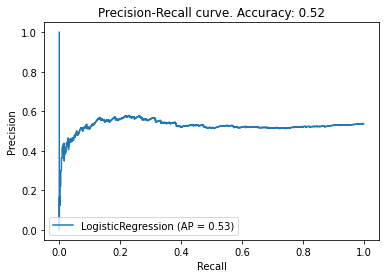

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr, X_val, y_val)
disp.ax_.set_title('Precision-Recall curve. Accuracy: {0:0.2f}'.format(accuracy_score(lr_pred, y_val)))

In [ ]:
# ! pip install catboost 
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=5,
                          learning_rate=1,
                          depth=4)
# Fit model
model.fit(X_train, y_train)
# Get predictions
cbr_pred = model.predict(X_val)
accuracy_score(cbr_pred.round(), y_val)

0:	learn: 0.4930822	total: 1.31ms	remaining: 5.25ms
1:	learn: 0.4901782	total: 4.27ms	remaining: 6.41ms
2:	learn: 0.4876443	total: 6.13ms	remaining: 4.08ms
3:	learn: 0.4865043	total: 8.4ms	remaining: 2.1ms
4:	learn: 0.4840139	total: 9.68ms	remaining: 0us


0.5100250626566416

word2vec + LSTM 

In [ ]:
# индекс для финансового индекса  
sp500_df = sp500_enrich[['dt', 'chng_prev', 'candle_h_prev', 
                         'Close_prev', 'Volume_prev', 'target']] 
sp500_df = sp500_df.sort_values(by='dt') 
sp500_idxs = np.arange(len(sp500_df))
sp500_df['idx'] = sp500_idxs
sp500_df['prev_idx'] = sp500_df['idx'] + 1

sp500_df = sp500_df.set_index('idx').join(sp500_df[['prev_idx', 'dt']].set_index('prev_idx'), 
                                  rsuffix='_prev', how='inner').reset_index()

# объединим
# связываем индекс с предыдущим 
w2v_united_df = reut_art_df.set_index('dt').join(
    sp500_df.drop(columns=['dt', 'prev_idx']).set_index('dt_prev'), 
    rsuffix='_fin', how='inner').reset_index()


w2v_united_df.head()
w2v_united_df.shape

(2660, 12)

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation

from keras.layers import Embedding
from keras import Sequential 
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense 
from keras.callbacks import EarlyStopping
from keras.backend import clear_session 
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import SGD
from keras.layers import Conv1D
from keras.layers import Conv2D 

max_sentence_len = 15
def list_cutter(arr):
  return arr[:max_sentence_len]

sentences = w2v_united_df['articles_concat'].apply(list_cutter)
w2v_emb_size = 128
w2v = Word2Vec(sentences, size=w2v_emb_size, min_count=3, 
                                    window=5, iter=1000)
# pretrained_weights = w2v.wv.syn0
pretrained_weights = w2v.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
def word2idx(word):
  if word in w2v.wv:
    return w2v.wv.vocab[word].index  # индекс 0 у слова stock 
  else:
    return 0
def idx2word(idx):
  return w2v.wv.index2word[idx]

In [ ]:
# prepare data 
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32) 
train_y = np.zeros([len(sentences)], dtype=np.int32) 
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence[:-1]):
    train_x[i, t] = word2idx(word)
  train_y[i] = word2idx(sentence[-1])

# model LSTM 
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_emb_size, 
                    weights=[pretrained_weights]))
model.add(LSTM(units=w2v_emb_size))
# model.add(Conv1D(filters=1, kernel_size=3, activation='softmax'))
# model.add(Dense(units=100, activation='tanh'))
model.add(Dense(units=1, activation='softmax'))
# model.add(Activation('softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 32 # 64

history = model.fit(train_x, train_y, 
                    # validation_data=(X_val, y_val), 
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.3, 
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                    )

clear_session() 

Epoch 1/5
59/59 [==============================] - 4s 39ms/step - loss: 0.0000e+00 - accuracy: 0.0192 - val_loss: 0.0000e+00 - val_accuracy: 0.0163
Epoch 2/5
59/59 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0307 - val_loss: 0.0000e+00 - val_accuracy: 0.0163
Epoch 3/5
59/59 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0234 - val_loss: 0.0000e+00 - val_accuracy: 0.0163
Epoch 4/5
59/59 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0265 - val_loss: 0.0000e+00 - val_accuracy: 0.0163
Epoch 5/5
59/59 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0182 - val_loss: 0.0000e+00 - val_accuracy: 0.0163


In [ ]:
pretrained_weights[0] 
w2v.wv.vectors.shape

(2094, 128)

word2vec + NN 

In [ ]:
# word2vec + NN 
import numpy as np 
import tensorflow as tf
tf.random.set_seed(13)
np.random.seed(13)

from keras.models import Sequential
from keras import layers
from keras.backend import clear_session 

# построение модели 
model = Sequential()
model.add(layers.Dense(100, input_dim=X_train.shape[1], activation='relu'))
# model.add(layers.Dense(100, input_dim=300, activation='relu'))
# model.add(layers.Dense(10, input_dim=100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# настройка и обучение 

model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
print(model.summary()) 

model.fit(X_train, y_train,
          epochs=100,
          verbose=False,
          validation_data=(X_val, y_val), 
          batch_size=8)

# почистить веса для перезапуска 
clear_session() 


# точность 
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(train_accuracy))
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(val_accuracy)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
None
Training Accuracy: 0.5424
Validation Accuracy:  0.5376


Transformer word2vec

In [ ]:
# ! pip install smaberta
from smaberta import TransformerModel

model = TransformerModel('roberta', 'roberta-base', num_labels=2, reprocess_input_data=True, 
                         num_train_epochs=3, learning_rate=0.001, # , output_dir='./saved_model/'
                         overwrite_output_dir=True, fp16=False)

In [ ]:
np.random.seed(13)

def list_joiner(arr):
  return ' '.join(arr)

X_bert_w2v = w2v_united_df['articles_concat'].apply(list_joiner)
y_bert_w2v = w2v_united_df['target']
X_train_bert_w2v, X_val_bert_w2v, y_train_bert_w2v, y_val_bert_w2v = train_test_split(X_bert_w2v, y_bert_w2v, test_size=0.3)



model.train(X_train_bert_w2v, y_train_bert_w2v)

bert_preds, bert_model_outputs = model.predict(X_val_bert_w2v) # bert_df.drop(columns='target'))
accuracy_score(bert_preds, y_val_bert_w2v) # bert_df['target'])

Starting Epoch:  0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


KeyboardInterrupt: ignored